# Ackley 1d toy exaples

In [227]:
import jax
import numpy as np
import seaborn as sns
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt

from functools import partial
from rebayes_mini.methods import gauss_filter
from rebayes_mini.methods import base_filter
from rebayes_mini.methods import low_rank_filter as lofi
from rebayes_mini.methods import low_rank_last_layer

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sns.set_palette("colorblind")

In [4]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = (7.2, 4.2)

plt.rcParams["font.size"] = 12
plt.rcParams["axes.spines.right"]= False
plt.rcParams["axes.spines.top"] = False
# plt.rc("text", usetex=True)

In [5]:
jnp.set_printoptions(suppress=True, precision=5, linewidth=200)

In [6]:
def ackley_1d(x, y=0):
    out = (-20*jnp.exp(-0.2*jnp.sqrt(0.5*(x**2 + y**2))) 
           - jnp.exp(0.5*(jnp.cos(2*jnp.pi*x) + jnp.cos(2*jnp.pi*y)))
           + jnp.e + 20)
    
    return out

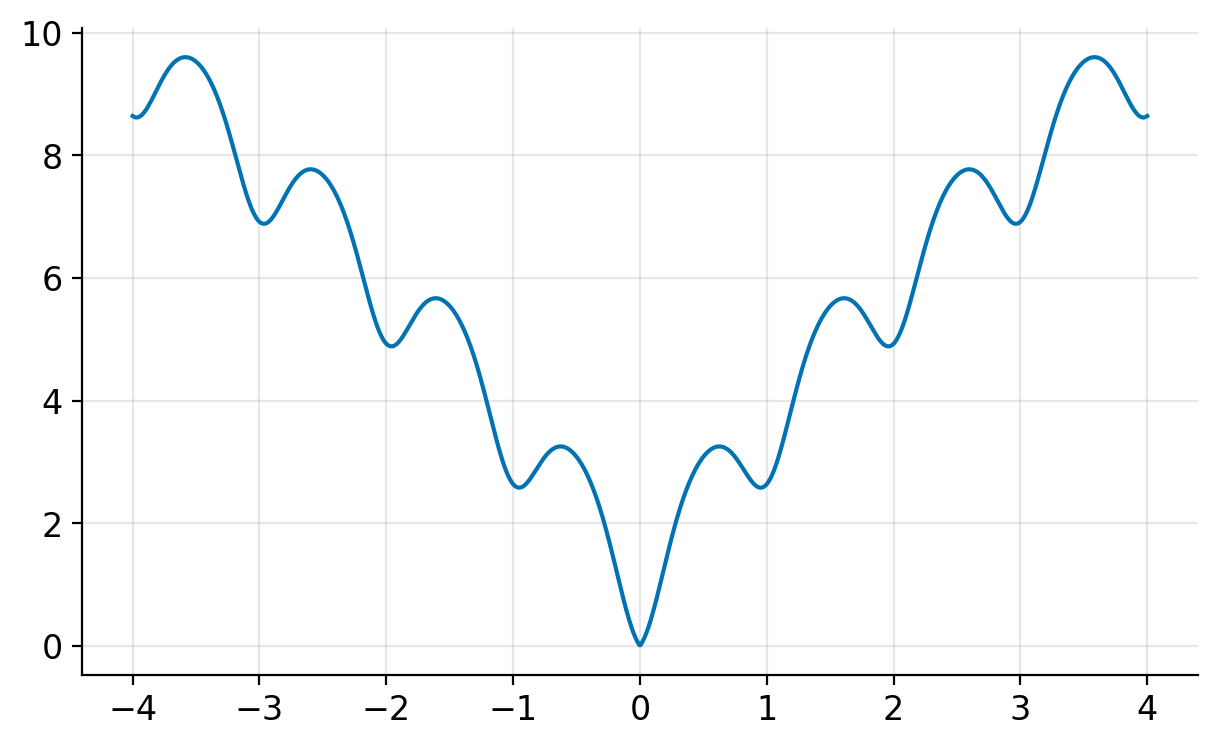

In [7]:
xrange = jnp.linspace(-4, 4, 1000)
yvals = ackley_1d(xrange)
ymean = yvals.mean()
ystd = yvals.std()
# yvals = (yvals - ymean) / ystd

plt.plot(xrange, yvals)
plt.grid(alpha=0.3)

## The BNN surrogate model

In [259]:
class MLP(nn.Module):
    n_hidden: int = 50

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.n_hidden)(x)
        x = jnp.sin(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(1, name="last_layer")(x)
        return x

In [249]:
key = jax.random.PRNGKey(3141)
key_data, key_train, key_sample = jax.random.split(key, 3)

## Training model

In [141]:
n_obs = 15
x_samples = jax.random.uniform(key_data, shape=(n_obs,1), minval=-4, maxval=4)
y_samples = ackley_1d(x_samples)
qlow, qhigh = 0.95, 0.05

In [142]:
res = {}

## Full-covariance EKF

In [143]:
%%time
model = MLP()
params_init = model.init(key_train, x_samples)

def cov_fn(y): return 0.0
agent = gauss_filter.GaussianFilter(model.apply, dynamics_covariance=0.0, variance=1e-2)
bel_init = agent.init_bel(params_init, cov=0.1 ** 2)

bel, hist = agent.scan(bel_init, y_samples, x_samples)
hist = jax.tree.map(np.array, hist)
bel = jax.block_until_ready(bel)

CPU times: user 8.49 s, sys: 107 ms, total: 8.6 s
Wall time: 6.79 s


In [144]:
L = jnp.linalg.cholesky(bel.cov)

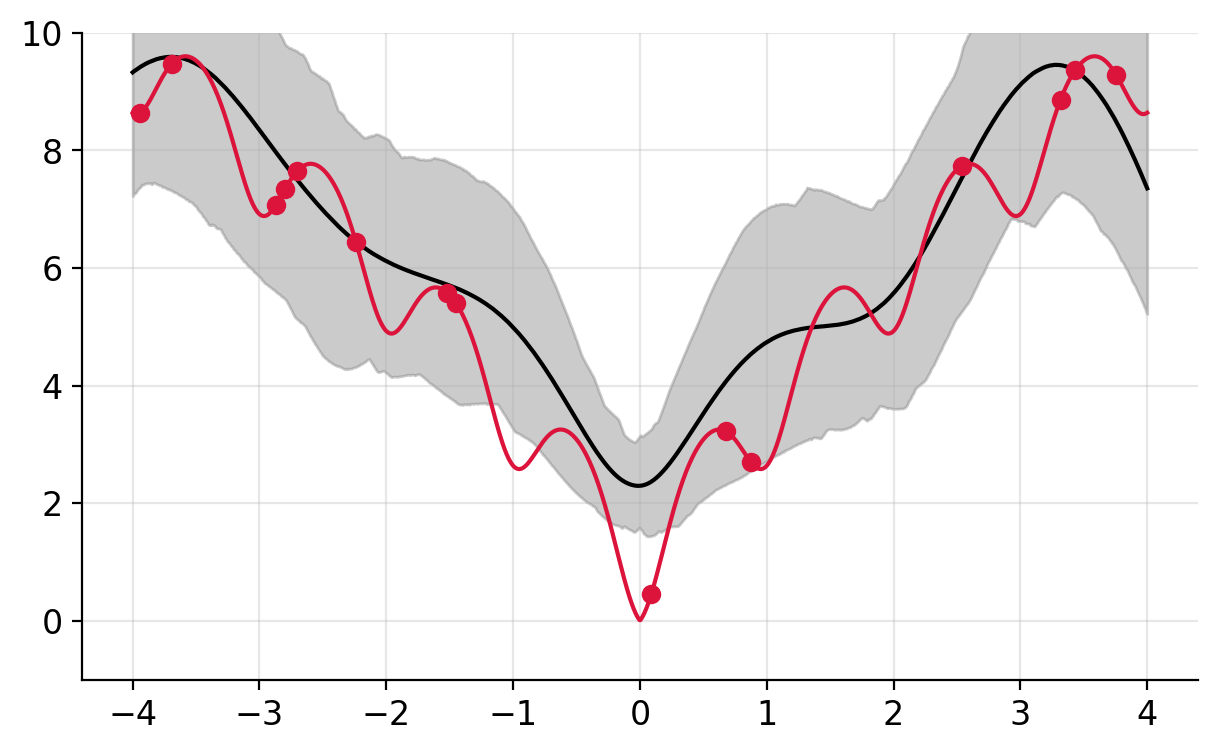

In [145]:
eps = jax.random.normal(key_sample, (100, len(bel.mean)))

sample_params = jnp.einsum("ji,sj->si", L, eps) + bel.mean

eval_samples = jax.vmap(agent.link_fn, in_axes=(0, None))(sample_params, xrange[:, None]).squeeze()

lbound = np.quantile(eval_samples, qlow, axis=0)
ubound = np.quantile(eval_samples, qhigh, axis=0)
meanpred = eval_samples.mean(axis=0)

res["full-cov-EKF"] = {
    "lbound": lbound,
    "ubound": ubound,
    "mean-pred": meanpred
}

plt.fill_between(xrange, lbound, ubound, color="tab:gray", alpha=0.4)

# plt.plot(xrange, eval_samples.T, c="tab:gray", alpha=0.4)
plt.plot(xrange, meanpred, c="black")
plt.plot(xrange, yvals, c="crimson")
plt.scatter(x_samples, y_samples, c="crimson", zorder=3)
plt.ylim(-1, 10)
plt.grid(alpha=0.3)

## LoFi
* $R_t$ cannot be set to zero

In [146]:
%%time
model = MLP()
params_init = model.init(key_train, x_samples)

agent = lofi.GaussianFilter(model.apply, dynamics_covariance=0.0, variance=1e-2, rank=20)
bel_init = agent.init_bel(params_init, cov=0.1 ** 2)

bel, hist = agent.scan(bel_init, y_samples, x_samples)
hist = jax.tree.map(np.array, hist)
bel = jax.block_until_ready(bel)

CPU times: user 2.72 s, sys: 182 ms, total: 2.91 s
Wall time: 1.24 s


In [147]:
@partial(jax.vmap, in_axes=(0, None))
def sample_lofi_params(key, bel):
    return agent._sample_lr_params(key, bel)

In [148]:
keys_samples = jax.random.split(key_sample, 100)
sample_params = sample_lofi_params(keys_samples, bel)

In [149]:
eval_samples = jax.vmap(agent.link_fn, in_axes=(0, None))(sample_params, xrange[:, None]).squeeze()

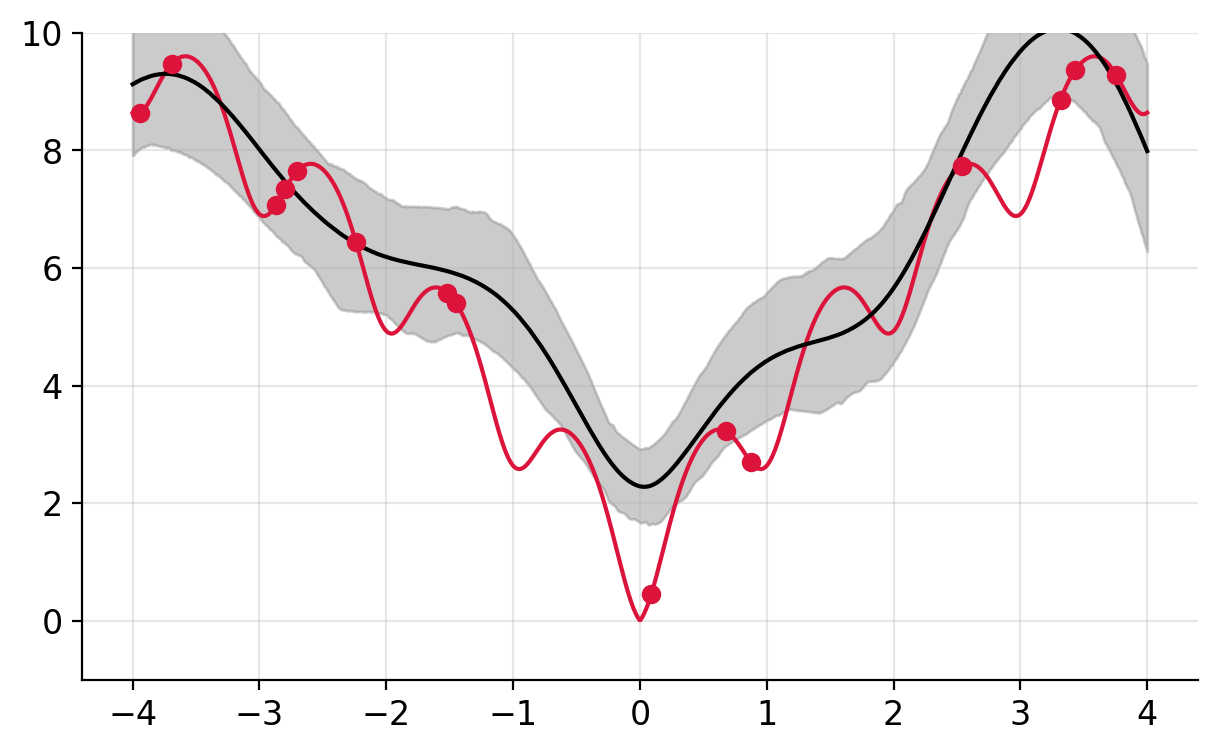

In [150]:
lbound = np.quantile(eval_samples, qlow, axis=0)
ubound = np.quantile(eval_samples, qhigh, axis=0)
meanpred = eval_samples.mean(axis=0)

res["LoFi-20"] = {
    "lbound": lbound,
    "ubound": ubound,
    "mean-pred": meanpred
}

plt.fill_between(xrange, lbound, ubound, color="tab:gray", alpha=0.4)

# plt.plot(xrange, eval_samples.T, c="tab:gray", alpha=0.4)
plt.plot(xrange, yvals, c="crimson")
plt.plot(xrange, meanpred, c="black")
plt.scatter(x_samples, y_samples, c="crimson", zorder=3)
plt.ylim(-1, 10)
plt.grid(alpha=0.3)

## Full-covariance ll-lr aware EKF

In [151]:
dim_last = 31

In [152]:
%%time
model = MLP()
params_init = model.init(key_train, x_samples)

def cov_fn(y): return 0.0
agent = base_filter.SquareRootFilter(model.apply, cov_fn, dynamics_covariance=0.0, n_inner=1)
bel_init = agent.init_bel(params_init, cov=0.001 ** 2)

# replacing last-layer covariance
bel_init = bel_init.replace(W=bel_init.W.at[-dim_last:, -dim_last:].set(jnp.eye(dim_last) * 10.0))

bel, _ = agent.scan(bel_init, y_samples, x_samples)
bel = jax.block_until_ready(bel)

CPU times: user 15min 20s, sys: 1min 23s, total: 16min 43s
Wall time: 36.4 s


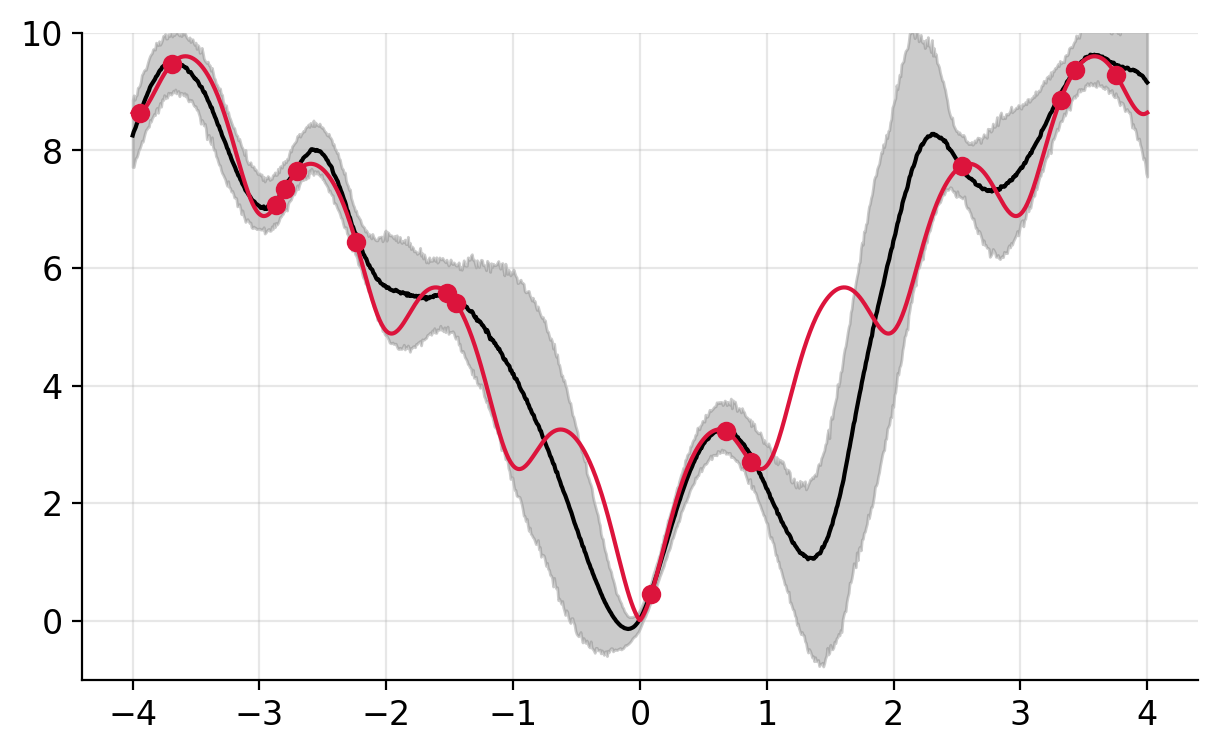

In [153]:
eps = jax.random.normal(key_sample, (100, len(bel.mean)))

sample_params = jnp.einsum("ji,sj->si", bel.W, eps) + bel.mean

eval_samples = jax.vmap(agent.mean_fn, in_axes=(0, None))(sample_params, xrange[:, None]).squeeze()

lbound = np.quantile(eval_samples, qlow, axis=0)
ubound = np.quantile(eval_samples, qhigh, axis=0)
meanpred = eval_samples.mean(axis=0)

res["newmethod"] = {
    "lbound": lbound,
    "ubound": ubound,
    "mean-pred": meanpred
}

plt.fill_between(xrange, lbound, ubound, color="tab:gray", alpha=0.4)

# plt.plot(xrange, eval_samples.T, c="tab:gray", alpha=0.3)
plt.plot(xrange, meanpred, c="black")
plt.plot(xrange, yvals, c="crimson")
plt.scatter(x_samples, y_samples, c="crimson", zorder=3)
plt.ylim(-1, 10)
plt.grid(alpha=0.3)

## Gaussian process

In [154]:
@partial(jax.vmap, in_axes=(0, None, None))
@partial(jax.vmap, in_axes=(None, 0, None))
def matern_kernel(u, v, length_scale=1.0, nu=1/2):
    """
    https://andrewcharlesjones.github.io/journal/matern-kernels.html
    """
    # Compute the distance between u and v
    r = jnp.abs(u - v)

    # Calculate the scaling factor
    scaled_distance = r / length_scale
    
    # Define the Matérn kernel based on the value of nu
    if nu == 1/2:
        kernel_value = jnp.exp(-scaled_distance)
    elif nu == 3/2:
        kernel_value = (1 + jnp.sqrt(3) * scaled_distance) * jnp.exp(-jnp.sqrt(3) * scaled_distance)
    elif nu == 5/2:
        kernel_value = (1 + jnp.sqrt(5) * scaled_distance + (5 * scaled_distance**2) / 3) * jnp.exp(-jnp.sqrt(5) * scaled_distance)
    else:
        raise ValueError(f"Unsupported nu value: {nu}")

    return kernel_value


In [155]:
@partial(jax.vmap, in_axes=(0, None, None))
@partial(jax.vmap, in_axes=(None, 0, None))
def kgauss(u, v, gamma2=1.0):
    return jnp.exp(-(u - v) ** 2 / (2 * gamma2))

kgauss = matern_kernel
sigma = 1.0
x = x_samples.squeeze()
# Estimate variance and covariances
var_train = kgauss(x, x, sigma)
cov_test_train = kgauss(xrange, x, sigma)
var_test = kgauss(xrange, xrange, sigma)

# Make predictions
K = jnp.linalg.solve(var_train, cov_test_train.T).T
mu_pred = K @ y_samples
sigma_pred = var_test - K @ var_train @ K.T
sigma_pred = jnp.diag(sigma_pred)

In [156]:
ubound = mu_pred.squeeze() + 2 * sigma_pred
lbound = mu_pred.squeeze() - 2 * sigma_pred

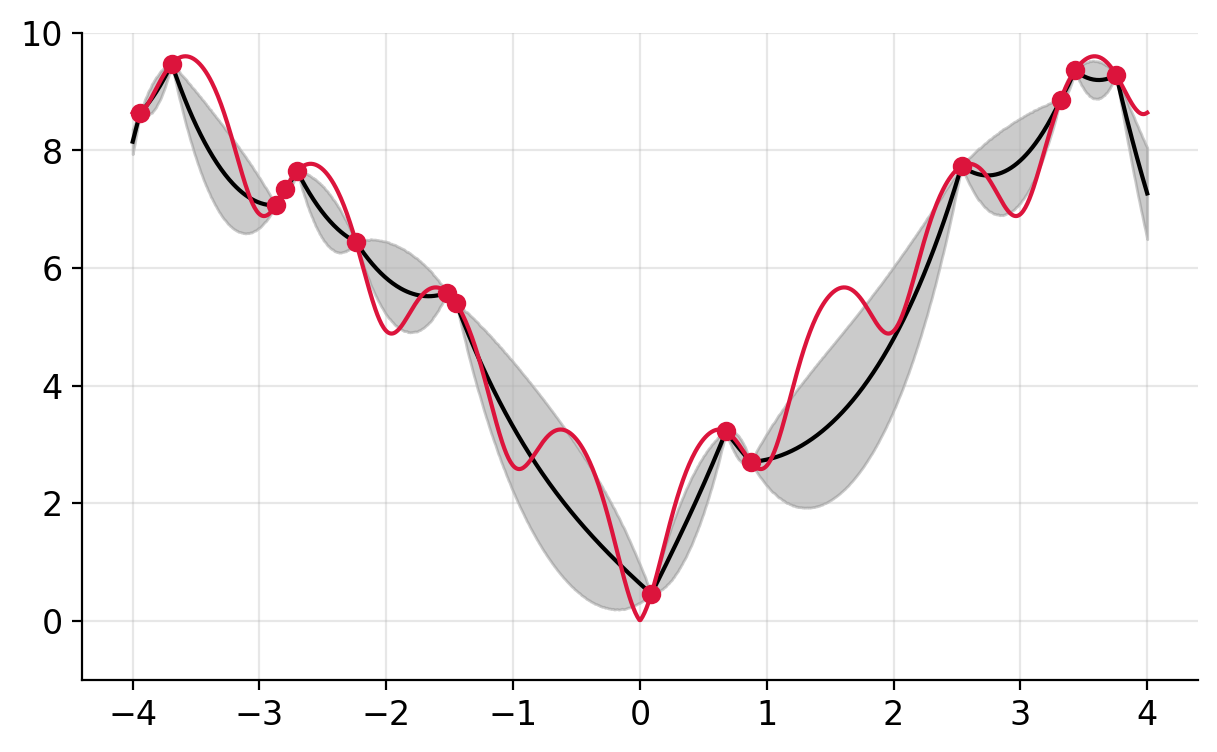

In [157]:
res["gp-matern"] = {
    "lbound": lbound,
    "ubound": ubound,
    "mean-pred": mu_pred,
}

plt.plot(xrange, mu_pred, c="black")
plt.plot(xrange, yvals, c="crimson")
plt.fill_between(xrange, lbound, ubound, color="tab:gray", alpha=0.4)
plt.scatter(x_samples, y_samples, c="crimson", zorder=3)
plt.ylim(-1, 10)
plt.grid(alpha=0.3)

## Results

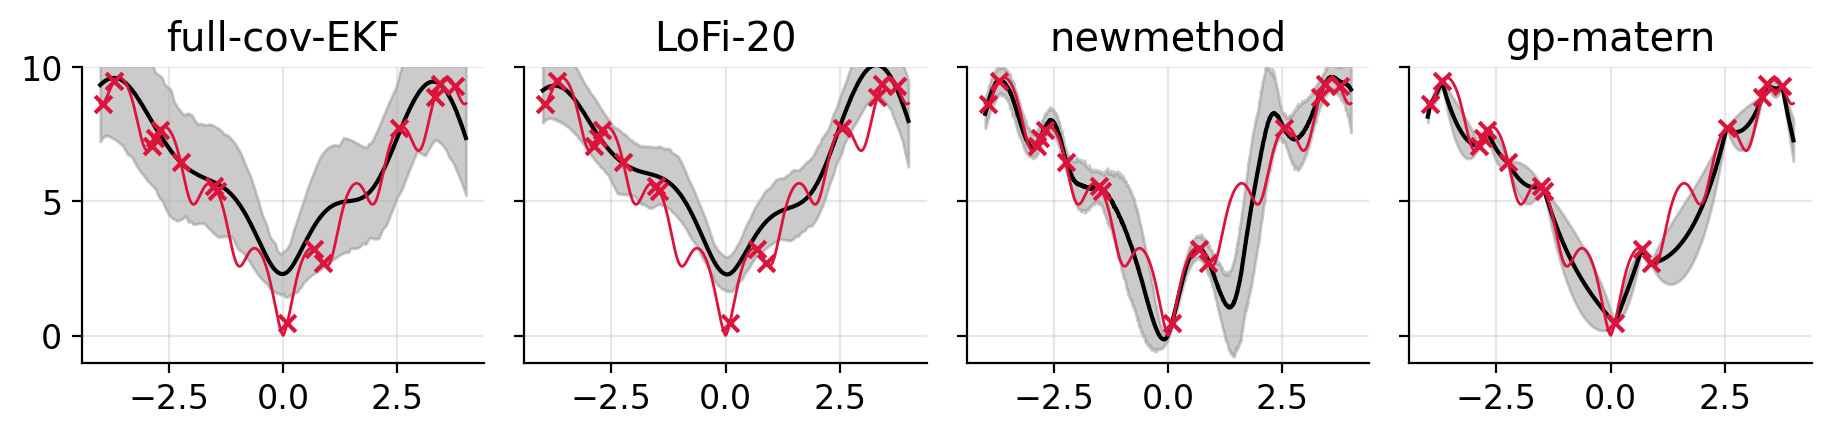

In [161]:
fig, axs = plt.subplots(1, 4, figsize=(6.2 * 1.8, 4.8 * 0.4), sharey=True)

for ax, method in zip(axs, res):
    ax.set_title(method)
    method_res = res[method]
    ax.plot(xrange, method_res["mean-pred"], c="black")
    ax.plot(xrange, yvals, c="crimson", linewidth=1)
    ax.fill_between(xrange, method_res["lbound"], method_res["ubound"], color="tab:gray", alpha=0.4)
    ax.scatter(x_samples, y_samples, c="crimson", zorder=3, marker="x")
    ax.set_ylim(-1, 10)
    ax.grid(alpha=0.3)
fig.subplots_adjust(wspace=0.1)

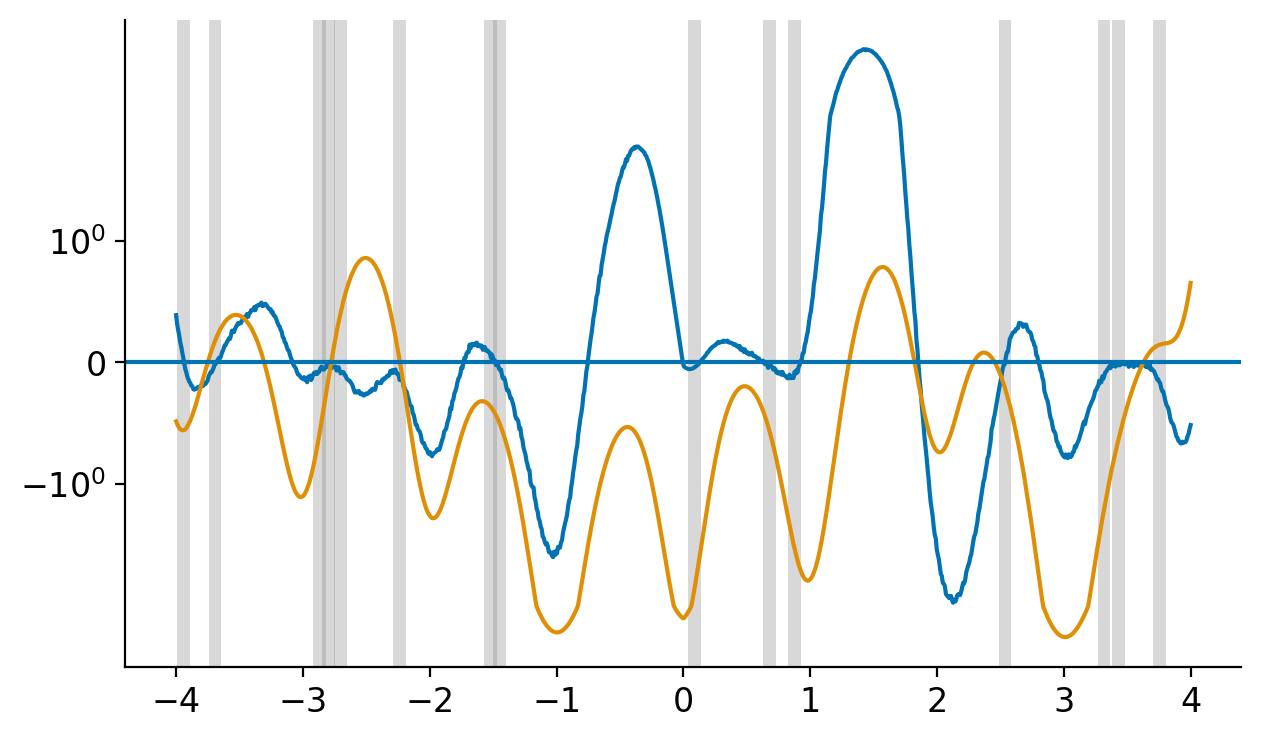

In [162]:
plt.plot(xrange, yvals - res["newmethod"]["mean-pred"].ravel())
plt.plot(xrange, yvals - res["LoFi-20"]["mean-pred"].ravel())
# plt.plot(xrange, yvals - res["gp-matern"]["mean-pred"].ravel())

plt.yscale("symlog")
delta = 0.05
for x in x_samples.ravel():
    plt.axvspan(x - delta, x + delta, alpha=0.3, facecolor="tab:gray", edgecolor=None)
plt.axhline(y=0.0)

## Thomspon-sampling BO

In [369]:
def eval_update(state, t, key, eval_fn, sample_fn):
    bel, x_next, y_next, y_best = state
    x_next = jnp.atleast_1d(x_next)
    # Update beliefs
    key_eval = jax.random.fold_in(key, t)
    bel = agent.update(bel, y_next, x_next)

    # Sample parameters from posterior
    params = sample_fn(key_eval, bel)
    sampled_points = eval_fn(params, xrange[:, None], bel)

    # Take next point
    x_next = xrange[sampled_points.argmin()]
    y_next = ackley_1d(x_next).squeeze()

    # y_best = y_next * (y_next > y_best) + y_best * (y_next <= y_best)
    y_best = y_next * (y_next < y_best) + y_best * (y_next >= y_best)

    out = {
        "x": x_next,
        "y": y_next,
        "y_best": y_best,
        "fn": sampled_points.squeeze(),
    }

    state_next = (bel, x_next, y_next, y_best)
    return state_next, out

## LoFi

In [370]:
key = jax.random.PRNGKey(314)
key_init_x, key_eval, key_params_init = jax.random.split(key, 3)

model = MLP()
params_init = model.init(key_params_init, x_samples)

In [408]:
agent = lofi.GaussianFilter(model.apply, dynamics_covariance=0.0, variance=1e-2, rank=20)
bel_init = agent.init_bel(params_init, cov=0.1 ** 2)

def sample_fn(key, bel):
    return agent._sample_lr_params(key, bel)

def eval_fn(mean, x, _):
    return agent.link_fn(mean, x)

In [409]:
x_init = jax.random.uniform(key_init_x, minval=-4, maxval=4)
y_init = ackley_1d(x_init)

In [410]:
steps = jnp.arange(20)
state_init = (bel_init, x_init, y_init, y_init)
_eval = partial(eval_update, key=key_eval, eval_fn=eval_fn, sample_fn=sample_fn)
bel_final, hist_lofi = jax.lax.scan(_eval, state_init, steps)

In [411]:
@partial(jax.vmap, in_axes=(0, None))
def run_multiple(key, steps):
    state_init = (bel_init, x_init, y_init, y_init)
    _eval = partial(eval_update, key=key, eval_fn=eval_fn, sample_fn=sample_fn)
    bel_final, hist_lofi = jax.lax.scan(_eval, state_init, steps)
    return hist_lofi["y_best"]

In [412]:
steps = jnp.arange(20)
keys = jax.random.split(key_eval, 25)
sims_lofi = run_multiple(keys, steps)

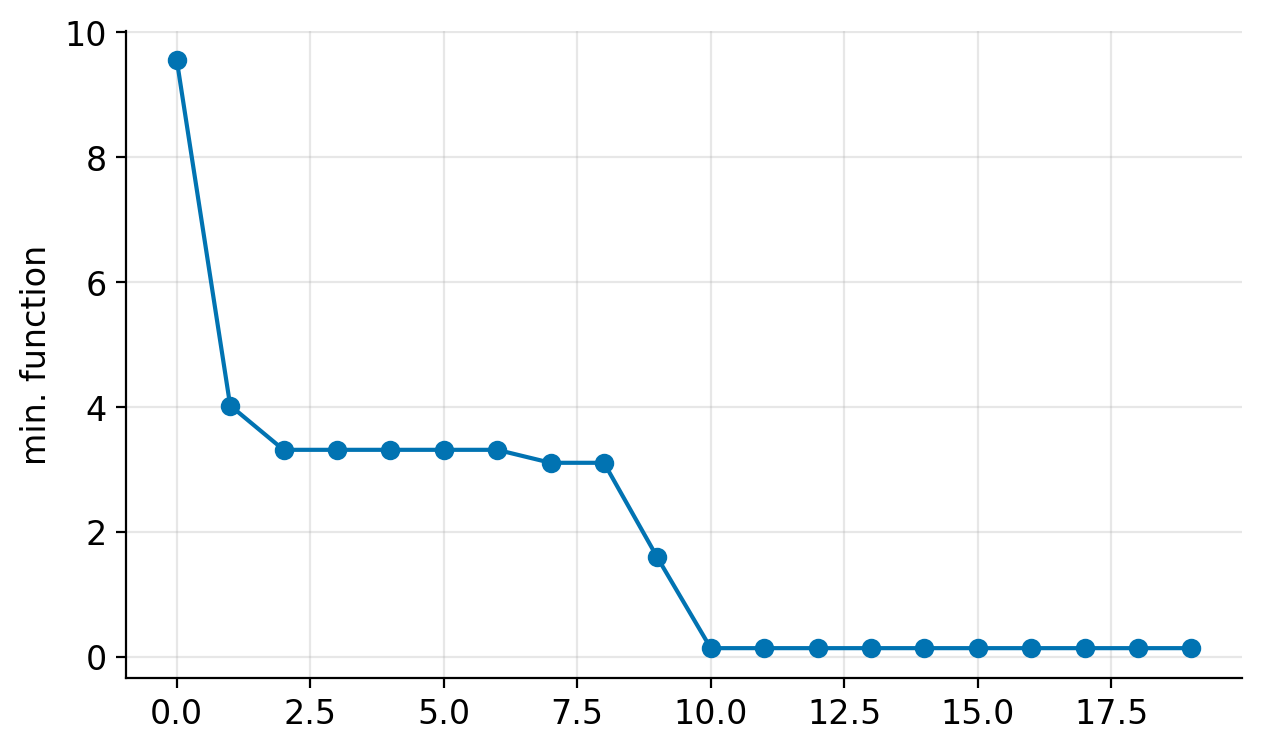

In [413]:
plt.plot(hist_lofi["y_best"], marker="o")
plt.ylabel("min. function")
# plt.yscale("log")
plt.grid(alpha=0.3)

In [414]:
hist_lofi["y"].min()

Array(0.13615, dtype=float32)

## LL-LRKF

In [464]:
def cov_fn(y): return 0.0

agent = low_rank_last_layer.LowRankLastLayer(
    model.apply,
    cov_fn,
    rank=20,
dynamics_hidden=0.0,
    dynamics_last=0.0,
)

bel_init = agent.init_bel(params_init, cov_hidden=0.001 ** 2, cov_last=2.0)

def sample_fn(key, bel):
    return agent.sample_params_last_layer(key, bel).squeeze()

def eval_fn(params_last, x, bel):
    params_hidden = bel.mean_hidden
    return agent.mean_fn(params_hidden, params_last, x)

In [465]:
@partial(jax.vmap, in_axes=(0, None))
def run_multiple(key, steps):
    state_init = (bel_init, x_init, y_init, y_init)
    _eval = partial(eval_update, key=key_eval, eval_fn=eval_fn, sample_fn=sample_fn)
    bel_final, hist = jax.lax.scan(_eval, state_init, steps)
    return hist["y_best"]

In [466]:
steps = jnp.arange(20)
keys = jax.random.split(key_eval, 25)
sims_l3rkf = run_multiple(keys, steps)

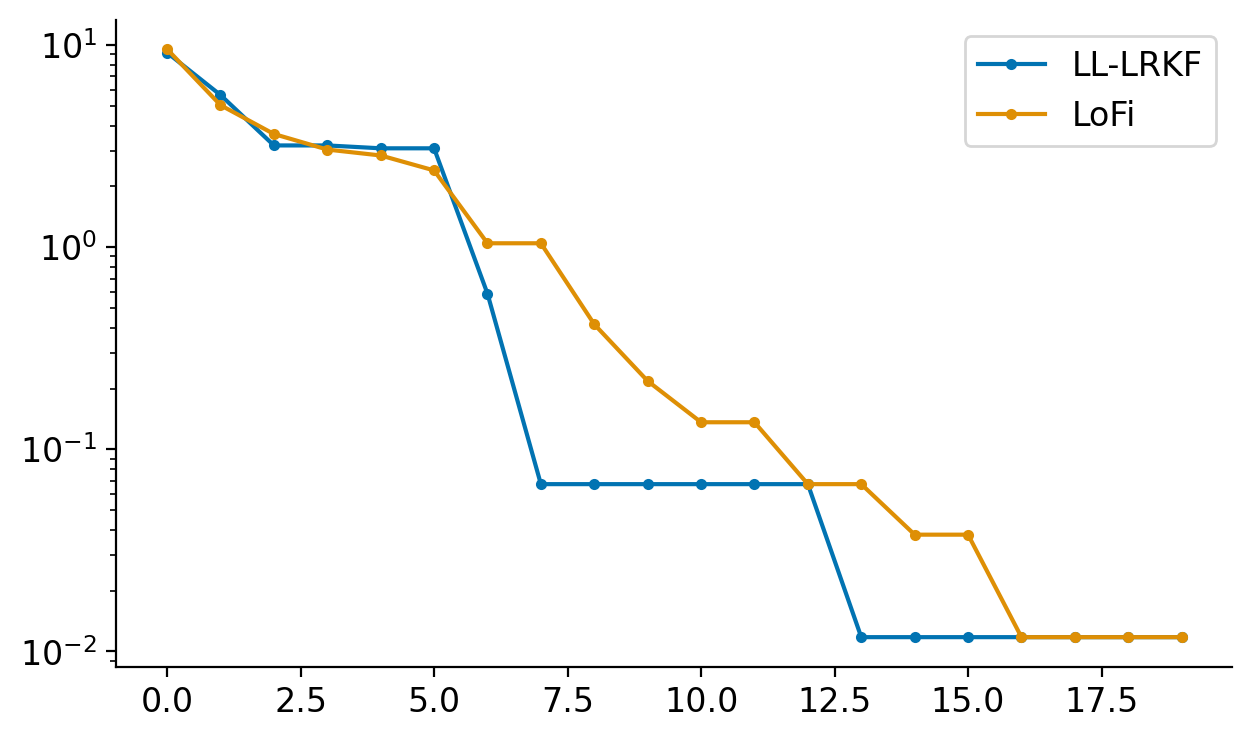

In [467]:
plt.plot(jnp.quantile(sims_l3rkf, 0.5, axis=0), marker="o", markersize=3, label="LL-LRKF")
plt.plot(jnp.quantile(sims_lofi, 0.5,axis=0), marker="o", markersize=3, label="LoFi")
plt.legend()
plt.yscale("log")